#  Comparison of Titanic problem solution using logistic regression and Random forest

The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we will build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).
In this code we are analysing titanic probelm using and logistic regression and random forest and compare there perforamance

## Variable Definition Key
- Survival 0 = No, 1 = Yes
- pclass Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex:Male/Female
- Age: Age in years
- sibsp : siblings / spouses aboard the Titanic
- parch :parents / children aboard the Titanic
- Ticket :Ticket number
- Fare: Passenger fare
- Cabin Cabin number
- Embarked Port : type of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

In [569]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

%matplotlib inline

## Get the data

In [570]:
# Importing the dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [571]:
#Analaysis of data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [572]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

In [573]:
#checking for null values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level

Let's continue on by visualizing some more of the data by help of plots.In this we analyze train_df (train data) using 
plots and cleaning process will be done on combine data(having both train & test data)

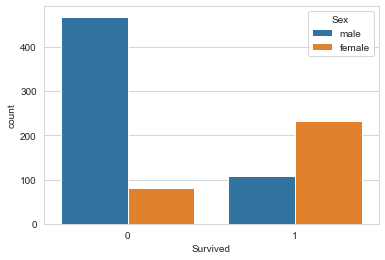

In [574]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Sex',data=train_df)

- By seeing this count plot we can analyze that number of female survival is more than no of male surviver so 'SEX' is   an Important feature

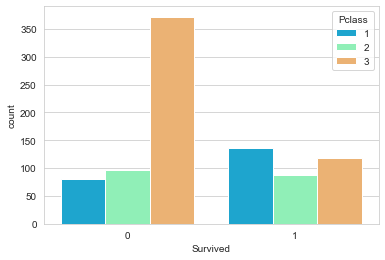

In [575]:
sns.countplot(x='Survived',hue='Pclass',data=train_df,palette='rainbow')

- By seeing this count plot we can analyze that people of class 3 have less chances of survival  compare to other 2     classes

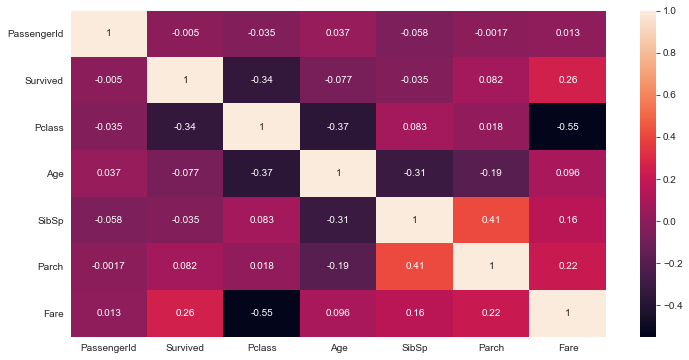

In [576]:
plt.figure(figsize =(12,6))
sns.heatmap(train_df.corr(),annot =True)


- By analysizing this heatmap,we can indentify that maximum correlation of survival is with Pclass(taking absolute       value)then Fare seems to have significant correlation

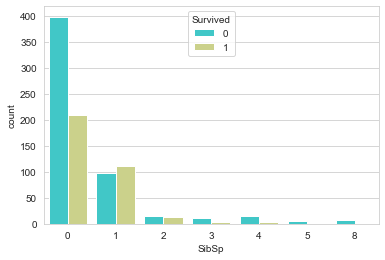

In [577]:
sns.countplot(x='SibSp',hue='Survived',data=train_df,palette='rainbow')

- persons having no siblings or less siblings have more chances of survival

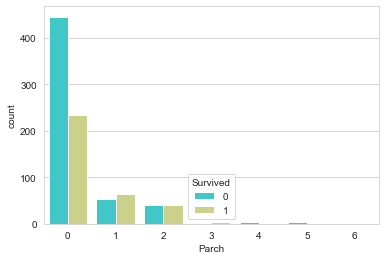

In [578]:
sns.countplot(x='Parch',hue='Survived',data=train_df,palette='rainbow')

- Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families 
 (Parch 5,6 ).

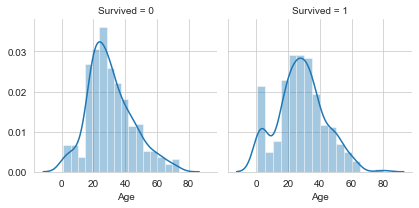

In [579]:
# Explore Age vs Survived
g = sns.FacetGrid(train_df, col='Survived')
g = g.map(sns.distplot, "Age")

- It seems that very young passengers have more chance to survive

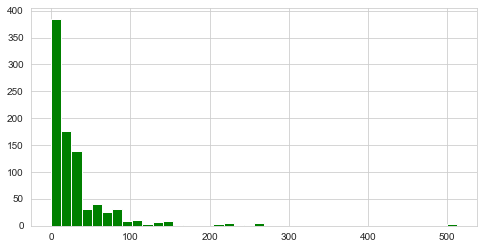

In [580]:
train_df['Fare'].hist(color='green',bins=40,figsize=(8,4))

- less price tickets are more purchased one

## DATA CLEANING

### Outlier Detection

In [581]:
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [582]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df, 2 ,["Age","SibSp","Parch","Fare"])


Since outliers can have a dramatic effect on the prediction (espacially for regression problems), i choosed to manage them.
oulier is detected by using (IQR) which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values . An outlier is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features (Age, SibSp, Sarch and Fare). Then, i considered outliers as rows that have at least two outlied numerical values.

In [583]:
train_df.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect 10 outliers. The 28, 89 and 342 passenger have an high Ticket Fare
The 7 others have very high values of SibSP. 
Next step is to drop outliers

In [584]:
# Drop outliers
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## Combine both test and train data

In [585]:
combine = pd.concat([train_df,test_df],axis=0)

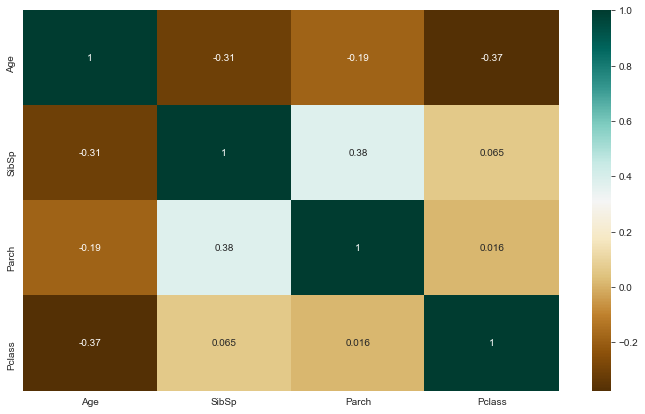

In [586]:
plt.figure(figsize=(12, 7))
g = sns.heatmap(train_df[["Age","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [587]:
combine['Age'] = combine.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))

combine is combine data of both test and train data .we are taking care of missing values of both dataset

In [588]:
combine.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

### Missing values in Embarked

Now,next step is to taking care of missing value of 'Embarked'which contain 2 missing values

In [589]:
combine['Embarked'] = combine['Embarked'].fillna(value=combine.Embarked.mode()[0])

We need to take care of missing values of Fare and also we already analyzed that maximum passengers purchased lower price tickets we assign levels to each of fare category

In [590]:
combine['Fare'] = combine['Fare'].fillna(value=combine['Fare'].median())
combine.loc[ combine['Fare'] <= 7.91, 'Fare'] = 0
combine.loc[(combine['Fare'] > 7.91) & (combine['Fare'] <= 14.454), 'Fare'] = 1
combine.loc[(combine['Fare'] > 14.454) & (combine['Fare'] <= 31), 'Fare']   = 2
combine.loc[ combine['Fare'] > 31, 'Fare'] = 3
combine['Fare'] = combine['Fare'].astype(int)

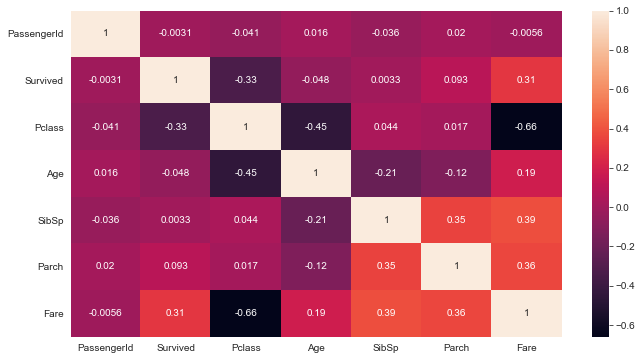

In [591]:
plt.figure(figsize=(11, 6))
sns.heatmap(combine.corr(),annot =True)

By Taking this heamap in account we can identify that sibsp and parch correlatiobn factor with survival is 
very less so we can drop these

In [592]:
combine =combine.drop(['SibSp','Parch'],axis=1)

### extarct title from name and map it 

In [593]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in combine["Name"]]
combine['Title'] = pd.Series(dataset_title)
combine['Title'] = combine['Title'].replace(['Rev', 'Dr', 'Col', 'Ms', 'Mlle', 'Major', 'the Countess', 
                                     'Capt', 'Dona', 'Jonkheer', 'Lady', 'Sir', 'Mme', 'Don'], 'Other')
title_category = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Other':5}
combine['Title'] = combine['Title'].map(title_category)


In [594]:
combine =combine.drop(['Name','Ticket'],axis=1)

### Extracting data for cabin

In [595]:
combine['Cabin']=combine['Cabin'].fillna('Missing')


In [596]:
combine['Cabin']=combine['Cabin'].str.get(0)


In [597]:
combine['Cabin'].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [598]:
cabin_category = {'A':1,'B':2, 'C':3, 'D':4, 'E':5,'F':6,'G':7,'T':8,'M':9}

In [599]:

combine['Cabin'] = combine['Cabin'].map(cabin_category)


## Converting Categorical Features

In [600]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1299 non-null   int64  
 1   Survived     881 non-null    float64
 2   Pclass       1299 non-null   int64  
 3   Sex          1299 non-null   object 
 4   Age          1299 non-null   float64
 5   Fare         1299 non-null   int64  
 6   Cabin        1299 non-null   int64  
 7   Embarked     1299 non-null   object 
 8   Title        1299 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 101.5+ KB


In [601]:
#converting categorical feature using pd_dummies and also dropping first column in conversion to reduce unnecessary features
sex = pd.get_dummies(combine['Sex'],drop_first=True)
embark = pd.get_dummies(combine['Embarked'],drop_first=True)

In [602]:
combine.drop(['Sex','Embarked'],axis=1,inplace=True)


In [603]:
combine = pd.concat([combine,sex,embark],axis=1)

In [604]:
combine.head()

,PassengerId,Survived,Pclass,Age,Fare,Cabin,Title,male,Q,S
0,1,0.0,3,22.0,0,9,1,1,0,1
1,2,1.0,1,38.0,3,3,3,0,0,0
2,3,1.0,3,26.0,1,9,2,0,0,1
3,4,1.0,1,35.0,3,3,3,0,0,1
4,5,0.0,3,35.0,1,9,1,1,0,1


## Extraction of train and test data from combine

In [605]:
dataset_train = combine[combine['PassengerId']<=891]
dataset_test = combine[combine['PassengerId']>891]
dataset_train = dataset_train.drop('PassengerId',axis = 1)
dataset_test = dataset_test.drop('PassengerId',axis = 1)


In [606]:
dataset_test.isnull().sum()

Survived    418
Pclass        0
Age           0
Fare          0
Cabin         0
Title         0
male          0
Q             0
S             0
dtype: int64

Great! Our data is ready for our model!

## splitting dataset 

In [607]:
#asssigning values to X and y
X = dataset_train.drop('Survived',axis = 1)
y = dataset_train['Survived']
X_test = dataset_test.drop('Survived',axis=1)

In [608]:
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
876    0.0
877    1.0
878    0.0
879    1.0
880    0.0
Name: Survived, Length: 881, dtype: float64

Splitting the dataset into the Training set and Test set

In [609]:

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [610]:
X_train.isnull().sum()

Pclass    0
Age       0
Fare      0
Cabin     0
Title     0
male      0
Q         0
S         0
dtype: int64

## Building a model using Logistic Regression

In [611]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,y_train)

/Users/parulgupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predicting a new result 

In [612]:
y_pred =classifier.predict(X_val)
acc_log = round(classifier.score(X_train, y_train) * 100, 2)
acc_log

79.97

### Confusion matrix

In [613]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
cm

array([[86, 19],
       [13, 59]])

### k-Fold Cross Validation


In [614]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print(accuracies.mean())
print(accuracies.std())


/Users/parulgupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/parulgupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

0.7899396378269617
0.05886259360694444


/Users/parulgupta/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [615]:
y_test=classifier.predict(X_test)


In [616]:
from sklearn.metrics import classification_report

In [617]:
print(classification_report(y_val,y_pred))


              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84       105
         1.0       0.76      0.82      0.79        72

    accuracy                           0.82       177
   macro avg       0.81      0.82      0.81       177
weighted avg       0.82      0.82      0.82       177



## Building a model using Random forest model

In [618]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=500)
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [619]:
y_pred =classifier.predict(X_val)
acc_log = round(classifier.score(X_train, y_train) * 100, 2)
acc_log

95.74

In [620]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
cm

array([[93, 12],
       [13, 59]])

In [621]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       105
         1.0       0.83      0.82      0.83        72

    accuracy                           0.86       177
   macro avg       0.85      0.85      0.85       177
weighted avg       0.86      0.86      0.86       177



In [622]:
y_test=classifier.predict(X_test)

## comparison between logistic regression and Random forest

|**Model**|Score|cm    |
|:----|:----|:-----|
|LR.  |80.02|86 19 | 
|     |     |13 59 |           
|RF.  |95.74|98 12 | 
|     |     |13 59 | 